In [2]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('enter phystech e-mail\n') 
    to_hash =  mail.strip().split('@')[0]    
    h = crc32(to_hash.encode('utf-8')) + 127
    seed = h%(2**32-1)
    rs = np.random.RandomState(seed)
    task1 = rs.randint(low=1, high=5)
    task2 = rs.randint(low=1, high=5)
    print ('Your tasks are 1.{}, 2.{}'.format(task1, task2))

enter phystech e-mail
akimenkova.ma@phystech.edu
Your tasks are 1.1, 2.3


## Задача 1.1

Выборка состоит из трех объектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

1. Провести отбор наиболее значимых признаков и построить регрессию X->Y
2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
3. Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).

In [127]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from statsmodels.regression.linear_model import OLS
import statsmodels.formula.api as sm
from PIL import Image
# from IPython.display import Image

In [170]:
X_test = np.load('/home/maria/regression/regression_x_test.npy')
X_train = np.load('/home/maria/regression/regression_x_train.npy')
Y_train = np.load('/home/maria/regression/regression_y_train.npy')

In [164]:
print(X_test.shape)
print(X_train.shape)
print(Y_train.shape)

(420, 620, 35)
(286, 604, 35)
(286, 604)


In [149]:
img = Image.fromarray((Y_train*255).astype('uint8'))
img.save('y.png')

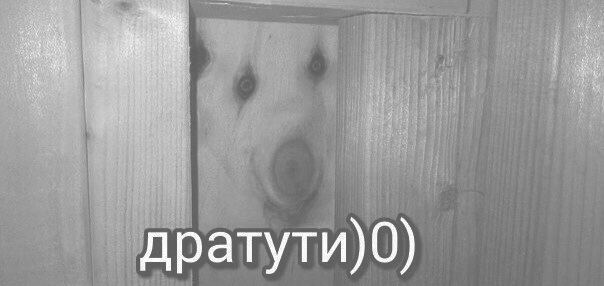

In [150]:
from IPython.display import Image
Image(filename='y.png')

Т.к элемент X[i,j] соответствует набору признаков для пикселя Y[i,j], преобразуем

In [171]:
x_train = list()
y = list()
x_test = list()
for i in range(286):
    for j in range(604):
        x_train.append(X_train[i][j])
        y.append(Y_train[i][j])
for i in range(420):
    for j in range(620):
        x_test.append(X_test[i][j])

In [172]:
X = pd.DataFrame(x_train)
X_t = pd.DataFrame(x_test)

In [173]:
X['y'] = y

In [174]:
print(X.shape)
print(X_t.shape)

(172744, 36)
(260400, 35)


Проведем отбор признаков по матрице корреляции

Здесь мы сначала построим correlation heatmap и увидим корреляцию независимых переменных. 

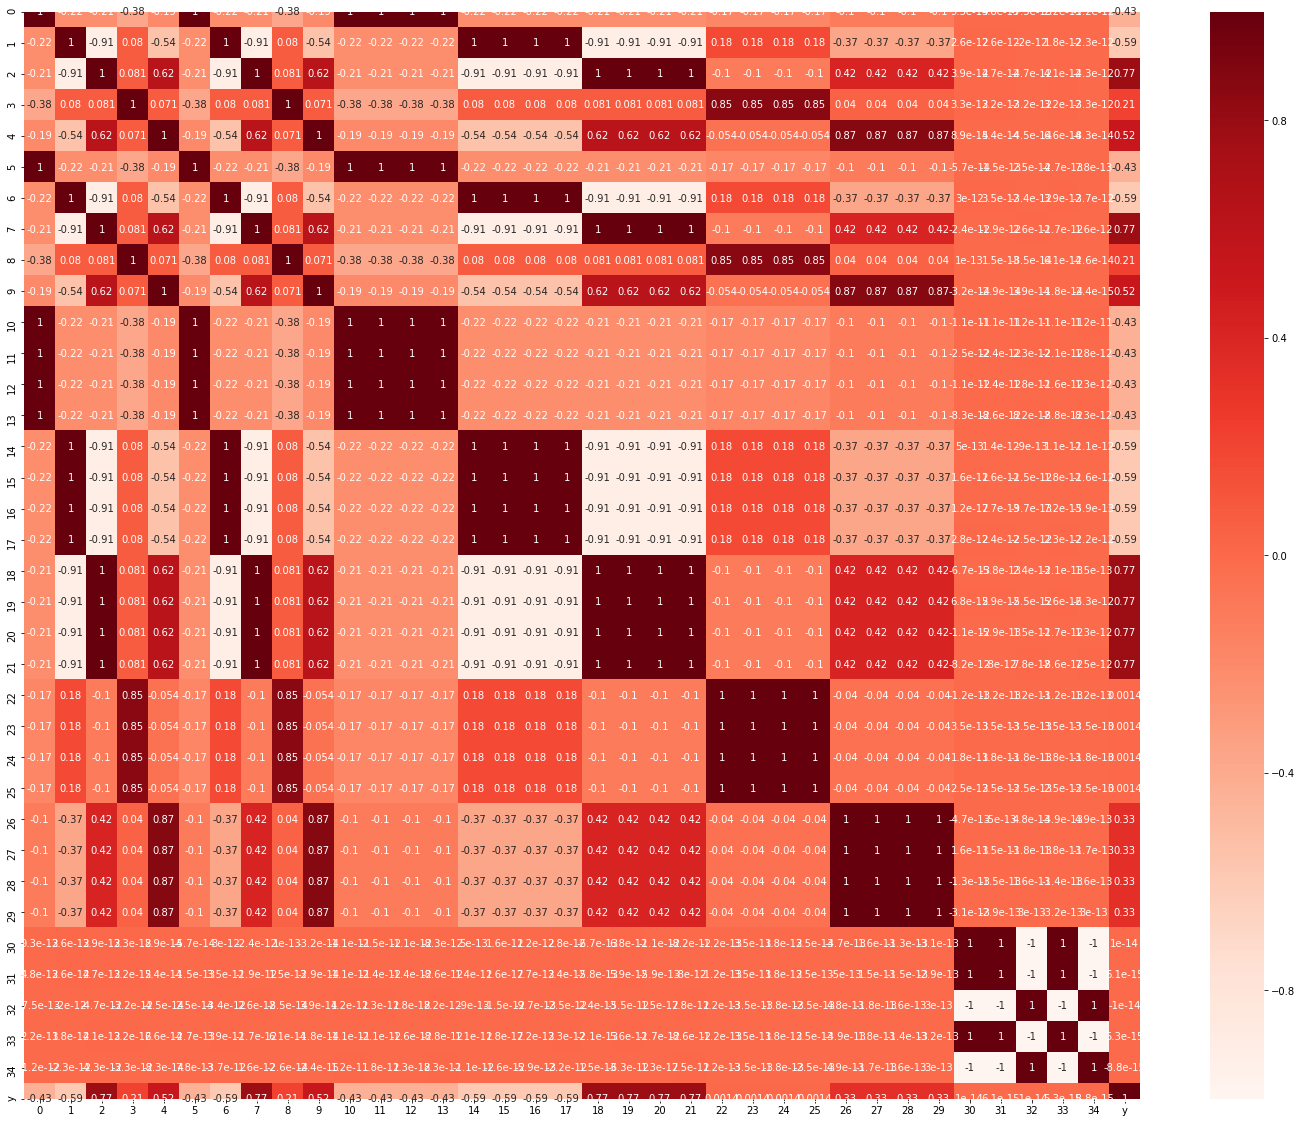

In [175]:
plt.figure(figsize=(25,20))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Мы будем выбирать только те объекты, которые имеют корреляцию выше 0,9

In [176]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.90:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

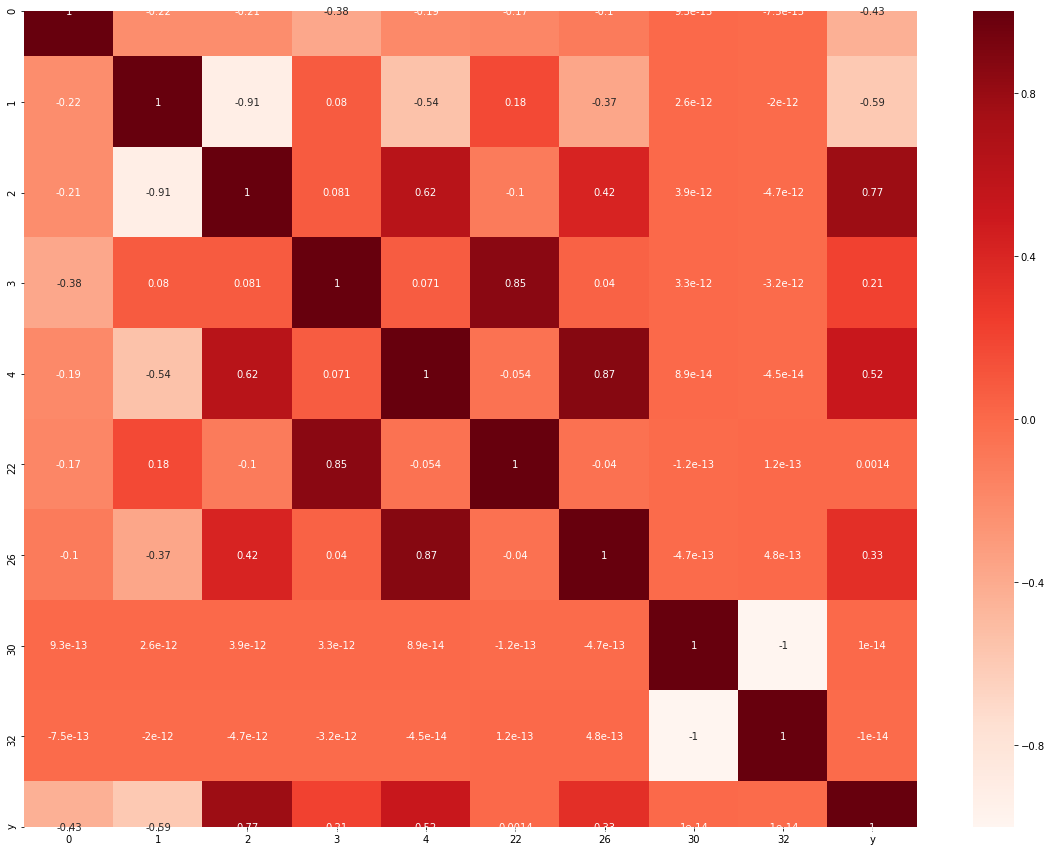

In [177]:
plt.figure(figsize=(20,15))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Проверим наличие пропусков

In [146]:
print(X.shape)
print(X.dropna().shape)

(172744, 10)
(172744, 10)


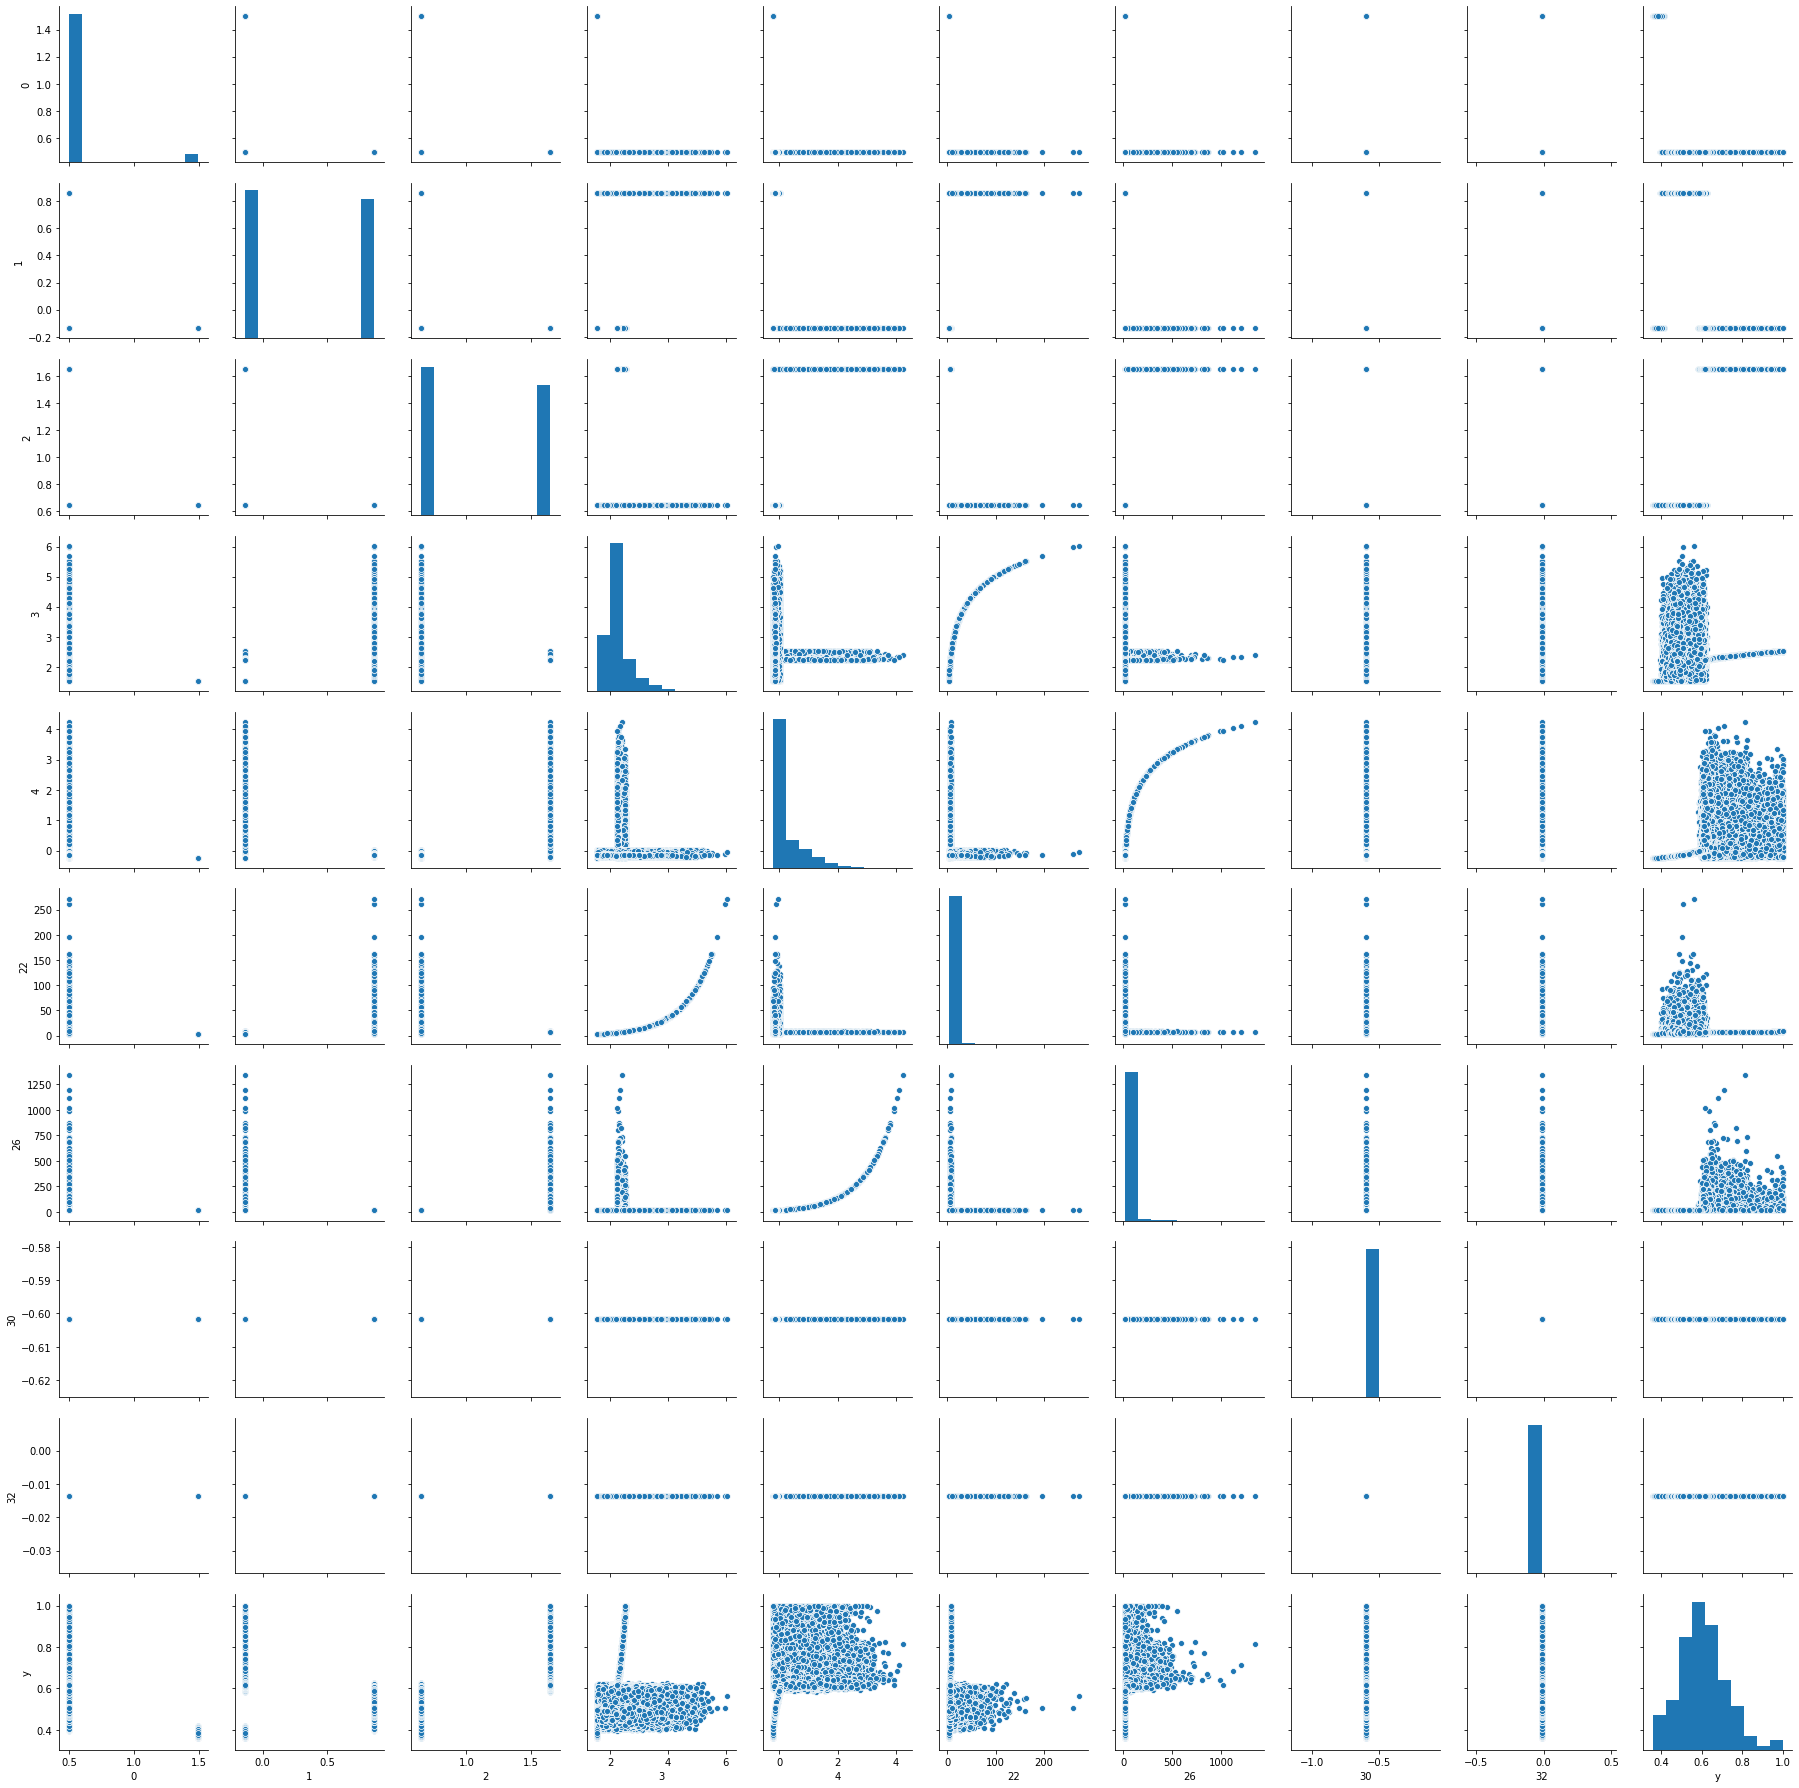

In [147]:
_ = sns.pairplot(X)

Поменяем название столбцов

In [178]:
for column in X.columns:
    if column =='y':
        continue
    X.rename(columns={column:'col'+str(column)}, inplace = True)
for column in X_t.columns:
    if column =='y':
        continue
    X_t.rename(columns={column:'col'+str(column)}, inplace = True)

Похоже, что col22 и col26 зависят от col3 и col4 -> удалим их

In [182]:
X = X.drop(columns=['col22','col26'])
X_t = X_t.drop(columns=['col22','col26'])

Добавим в формулу межакторное взаимодействие между col3 и col4

In [183]:
formula = 'y~col0+col1+col2+col3+col4+col3:col4+col30+col32'
model1 = OLS.from_formula(formula, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 9.338e+04
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        17:14:48   Log-Likelihood:             2.5153e+05
No. Observations:              172744   AIC:                        -5.031e+05
Df Residuals:                  172737   BIC:                        -5.030e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    5.38e+08   2.23e+09      0.241      0.810   -3.84e+09    4.92e+09
col0        2.806e+09   6.68e+09      0.420      0.674   -1.03e+10    1.59e+10
col1        2.806e+09   6.68e+09      0.420      0.674   -1.03e+10    1.59e+10
col2        2.806e+09   6.68e+09      0.420      0.674   -1.03e+10    1.59e+10
col3           0.0714      0.000    181.082      0.000       0.071       0.072
col4          -1.6143      0.006   -249.000      0.000      -1.627      -1.602
col3:col4      0.6998      0.003    250.666      0.000       0.694       0.705
col30       1.026e+10   2.11e+10      0.485      0.628   -3.12e+10    5.17e+10
col32      -3.223e+08   6.18e+08     -0.522      0.602   -1.53e+09    8.88e+08
==============================================================================
Omnibus:                    32617.809   Durbin-Watson:                   0.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106775.306
Skew:                           0.959   Prob(JB):                         0.00
Kurtosis:                       6.341   Cond. No.                     1.95e+29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.99e-53. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

0.76 < 0.85, попробуем добавить взаимодействие других признаков

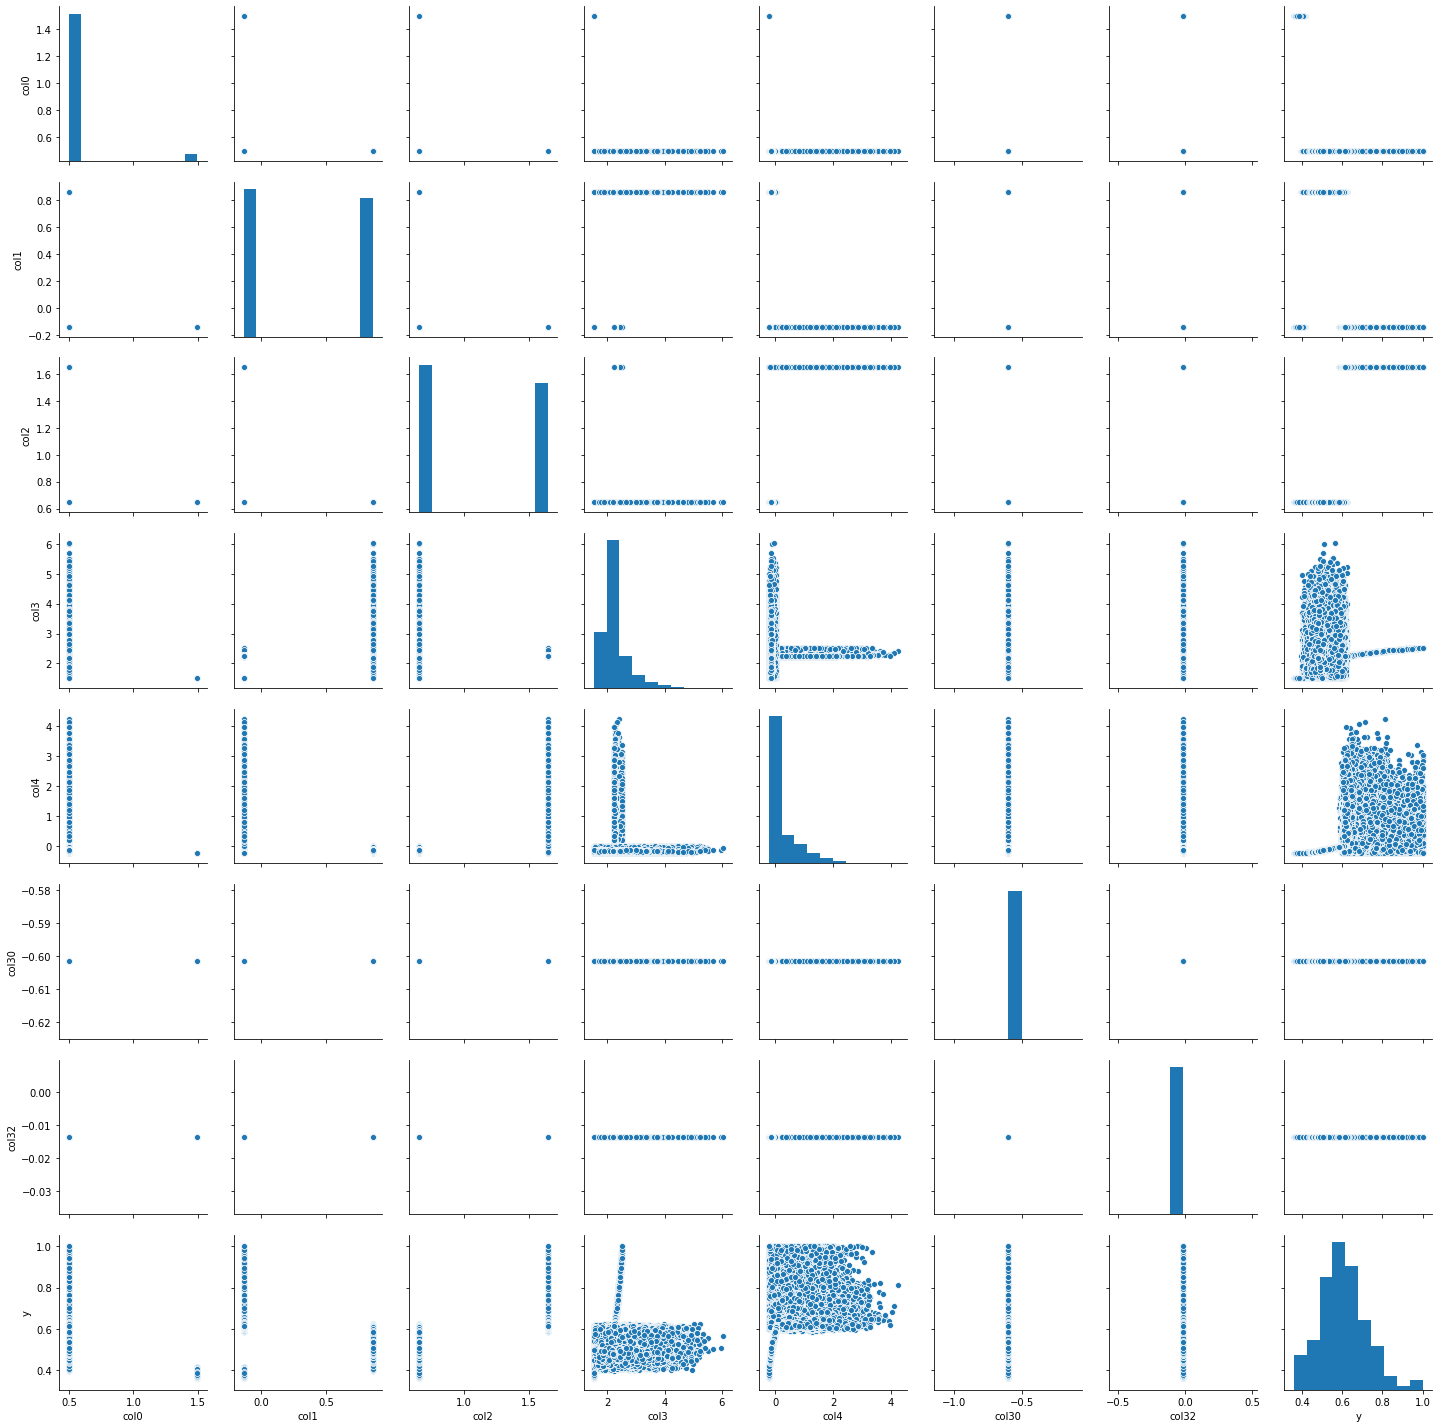

In [184]:
_ = sns.pairplot(X)

In [213]:
formula = 'y~col1+col4+col0:col3+col0:col4+col2:col3'
model2 = OLS.from_formula(formula, X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 3.483e+05
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        17:28:47   Log-Likelihood:             3.3444e+05
No. Observations:              172744   AIC:                        -6.689e+05
Df Residuals:                  172738   BIC:                        -6.688e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7844      0.004   -485.059      0.000      -1.792      -1.777
col1           2.6926      0.004    626.796      0.000       2.684       2.701
col4          10.5838      0.017    620.560      0.000      10.550      10.617
col0:col3     -1.6045      0.002   -644.867      0.000      -1.609      -1.600
col0:col4    -21.2900      0.034   -620.241      0.000     -21.357     -21.223
col2:col3      1.2302      0.002    665.087      0.000       1.227       1.234
==============================================================================
Omnibus:                    12408.200   Durbin-Watson:                   0.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19952.092
Skew:                          -0.566   Prob(JB):                         0.00
Kurtosis:                       4.221   Cond. No.                     1.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.91 > 0.85 -> модель подходит

In [214]:
X['res'] = model2.resid

In [220]:
X.head()

,col0,col1,col2,col3,col4,col30,col32,y,res
0,0.496714,-0.138264,1.647689,2.288549,0.859431,-0.601707,-0.013497,0.658741,-0.007147
1,0.496714,-0.138264,1.647689,2.293655,-0.079660,-0.601707,-0.013497,0.671523,0.007622
2,0.496714,-0.138264,1.647689,2.296195,1.243614,-0.601707,-0.013497,0.660211,-0.018464
3,0.496714,-0.138264,1.647689,2.296195,0.714635,-0.601707,-0.013497,0.662597,-0.011421
4,0.496714,-0.138264,1.647689,2.288549,0.422087,-0.601707,-0.013497,0.658827,-0.003210


Финальное изображение

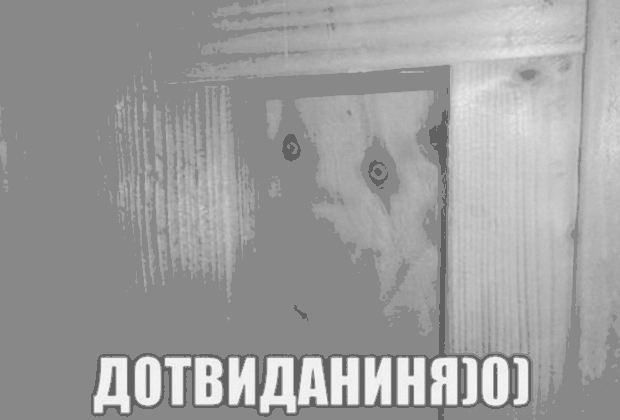

In [217]:
from PIL import Image
img_test = Image.fromarray((np.array(model2.predict(X_t)).reshape((X_test.shape)[0],(X_test.shape)[1])*255).astype('uint8'))
img_test.save('test.png')
from IPython.display import Image
Image(filename='test.png')